In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import igraph as ig
import os
import pdb
import nltk
import string
import json
import random
import pickle
import pandas as pd
import seaborn as sns
import scipy

from IPython.display import clear_output
from os import makedirs
from os.path import join, exists
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
logging.root.level = logging.INFO

In [3]:
INPUT_DIR = join('tmp', 'parsed')
OUTPUT_DIR = join('tmp')
makedirs(OUTPUT_DIR, exist_ok=True)

In [4]:
np.random.seed(1234)

In [5]:
plt.style.use('classic')

In [6]:
import math

def intra_cluster_similarity(vectors):
    matx = scipy.sparse.vstack((vectors))
    return np.sum(cosine_similarity(matx, matx)) / math.pow(len(vectors), 2)

In [7]:
def intra_cluster_overall_similarity(vectors):
    similarity_topics = {}
    for k, values in vectors.items():
        if len(values) > 0:
            similarity_topics[k] = intra_cluster_similarity(values)

    return sum(similarity_topics.values()) / len(similarity_topics.values())

In [8]:
def intra_cluster_weighted_similarity(vectors):
    weighted = 0.
    n = 0.
    for k, values in vectors.items():
        n += len(values)
            
    for k, values in vectors.items():
        if len(values) > 0:
            weighted += len(values) * intra_cluster_similarity(values)

    return weighted / n

In [9]:
def inter_cluster_overall_similarity2(vectors):
    similarity_topics = {}
    for k, values in vectors.items():
        if len(values) > 0:
            matx = scipy.sparse.vstack((values))
            centroid1 = matx.sum(axis=0) / len(values)
            similarities = []
            for k2, values2 in vectors.items():
                if len(values2) > 0 & k != k2:
                    matx2 = scipy.sparse.vstack((values2))
                    centroid2 = matx2.sum(axis=0) / len(values2)
                    similarities.append(cosine_similarity(centroid1, centroid2))
            similarity_topics[k] = np.sum(similarities) / len(similarities)
            
    return sum(similarity_topics.values()) / len(similarity_topics.values())

In [10]:
def cluster_centroids(vectors):
    centroids = {}
    for k, values in vectors.items():
        matx = scipy.sparse.vstack((values))
        centroids[k] = scipy.sparse.csr_matrix(matx.sum(axis=0) / len(values))
    return centroids

In [11]:
def inter_cluster_overall_similarity(vectors):
    topic_centroids = cluster_centroids(vectors)
    matx_c = scipy.sparse.vstack((topic_centroids.values()))
    matx_c_c = cosine_similarity(matx_c)
    matx_c_c_s = sum(matx_c_c) / len(matx_c_c)

    return sum(matx_c_c_s) / len(matx_c_c_s)

In [12]:
def purity_score(labels_true):
    nh = np.bincount(labels_true)

    return nh[np.argmax(nh)] / sum(nh)

In [13]:
def entropy_score(labels_true):
    entropy = 0.
    cats = np.unique(labels_true)
    ci = len(cats)
    if ci == 1: # math.log(1,2) == 0.0, causes div by zero when normalizing
        ci += 1
    nh = np.bincount(labels_true)
    n = len(labels_true)
    
    for j in cats:
        p_category = nh[j] / n
        entropy += p_category * math.log(p_category, 2)
    
    return -((1 / math.log(ci, 2)) * entropy)

In [14]:
def entropy_weighted_score(labels_size, labels_true):
    entropy = 0.
    n = 0.
    for i in (np.arange(labels_size) + 1):
        try:
            n += len(labels_true[i])
        except:
            n += 0.
        
    for i in (np.arange(labels_size) + 1):
        try:
            labels_true_topic = labels_true[i]
            ni = len(labels_true_topic)
            entropy += (ni / n) * entropy_score(labels_true_topic)
        except:
            entropy += 0.
    return entropy

In [15]:
def purity_weighted_score(labels_size, labels_true):
    purity = 0.
    n = 0.
    for i in (np.arange(labels_size) + 1):
        try:
            n += len(labels_true[i])
        except:
            n += 0.
        
    for i in (np.arange(labels_size) + 1):
        try:
            labels_true_topic = labels_true[i]
            ni = len(labels_true_topic)
            purity += (ni / n) * purity_score(labels_true_topic)
        except:
            purity += 0.
    return purity

In [16]:
from nltk.stem.porter import PorterStemmer

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    return tokens

In [17]:
def text_preprocess(text):
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]

In [18]:
def gensim_tokenize(text):
    tokens = [token for token in simple_preprocess(text) if token not in STOPWORDS]
    stems = []
    for item in tokens:
        stems.append(PorterStemmer().stem(item))
    return stems

In [19]:
import re

#compile regular expressions that match repeated characters and emoji unicode
emoji = re.compile(u'[^\x00-\x7F\x80-\xFF\u0100-\u017F\u0180-\u024F\u1E00-\u1EFF]',re.UNICODE)
multiple = re.compile(r"(.)\1{1,}", re.DOTALL)

def text_format(text):

    #strip emoji
    stripped = emoji.sub('',text)

    #strip URLs
    stripped = re.sub(r'http[s]?[^\s]+','', stripped)

    #strip html '&amp;', '&lt;', etc.  
    stripped = re.sub(r'[\&].*;','',stripped)

    #strip punctuation
    stripped = re.sub(r'[#|\!|\-|\+|:|//]', " ", stripped)

    #strip whitespace down to one.
    stripped = re.sub('[\s]+' ,' ', stripped).strip()

    #strip multiple occurrences of letters
    stripped = multiple.sub(r"\1\1", stripped)

    #strip all non-latin characters
    stripped = re.sub('[^a-zA-Z0-9|\']', " ", stripped).strip()

    return stripped

In [ ]:
from gensim import matutils
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.corpora import Dictionary
from nltk.tag import pos_tag

print("Building vocabulary...")

docs = {}
doc_tokens = {}
count = 0

for fname in os.listdir(INPUT_DIR):
    if fname != '.DS_Store':
        with open(join(INPUT_DIR, fname), 'r') as f:
            doc = json.load(f)
            docs[doc['id']] = doc
            text = doc['body']
            table = str.maketrans({key: None for key in string.punctuation})
            text = text.lower().translate(table)
            text = text_format(text)
            tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
            words = [word for word,pos in tagged if pos in ['NN', 'NNS', 'NNP', 'NNPS']]
            docs[doc['id']]["text"] = " ".join(words)
            clear_output(wait=True)
            count += 1
            print(count)

In [20]:
docs = pickle.load(open('tmp/docs.pickle', 'rb'))
token_keys = [x[0] for x in docs.items()]
token_values = [x[1]["text"] for x in docs.items()]
print(len(token_values))

9095


In [21]:
section_id = {}
count = 0
for k, v in docs.items():
    try:
        section_id[v['sectionId']]
    except:
        count += 1
        section_id[v['sectionId']] = count
        
len(section_id.values())

84

# TF-IDF Vectorizer

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

print("Processing TF-IDF")

vectorizer_tfidf = TfidfVectorizer(tokenizer=tokenize, norm='l2', stop_words='english')
X_tfidf = vectorizer_tfidf.fit_transform(token_values)

print(X_tfidf.shape)

Processing TF-IDF
(9095, 91268)


In [33]:
pickle.dump(X_tfidf, open('tmp/X_tfidf.pickle', 'wb'))

In [29]:
X_tfidf = pickle.load(open('tmp/X_tfidf0.pickle', 'rb'))

print(X_tfidf.shape)

(9095, 69281)


In [31]:
print(X_tfidf.shape)

(9095, 69281)


# Add Keywords to docs

In [28]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [29]:
def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

In [30]:
for i, key in enumerate(token_keys):
    print('{0}\r'.format(i/len(token_keys)))
    clear_output(wait=True)
    docs[key]['top_tfidf'] = top_feats_in_doc(X_tfidf, vectorizer_tfidf.get_feature_names(), i, 50)
    
print(docs['2016-05-20-28']['top_tfidf'])

          feature     tfidf
0            bull  0.331890
1            citi  0.290126
2          soccer  0.237421
3             red  0.206794
4         glidden  0.187779
5             nyc  0.181412
6           derbi  0.178271
7            team  0.170859
8              fc  0.165945
9          jersey  0.162983
10            fan  0.159129
11           york  0.149571
12             ml  0.149179
13        stadium  0.146739
14          yanke  0.146338
15       ferrezza  0.140834
16           club  0.140347
17            new  0.136129
18            esc  0.134774
19        support  0.132005
20        rivalri  0.118097
21         hudson  0.094977
22          river  0.088056
23          giant  0.082339
24           mlss  0.078902
25           rail  0.075909
26            say  0.070395
27          sport  0.068727
28          leagu  0.066341
29         subway  0.065955
30           play  0.065382
31         yorker  0.063552
32          metro  0.059355
33        inaugur  0.059201
34       harrison  0

# Add Vector to docs

In [81]:
for i, key in enumerate(token_keys):
    docs[key]['tfidf'] = X_tfidf[i]

docs['2016-05-20-28']['tfidf']

<1x88946 sparse matrix of type '<class 'numpy.float64'>'
	with 374 stored elements in Compressed Sparse Row format>

# Add Section ID to docs

In [82]:
for k, v in docs.items():
    docs[k]['section_id'] = section_id[v['sectionId']]

# Add Keyword

In [83]:
for k, v in docs.items():
    docs[k]['tags'] = []
    for keyword in v['keyword']:
        docs[k]['tags'].append(keyword['webTitle'])

docs['2016-05-20-28']['tags']

['MLS',
 'New York Red Bulls',
 'New York City FC',
 'US sports',
 'Football',
 'Sport']

In [84]:
def docs_to_tag_data(docs):
    d = []
    for key, vs in docs.items():
        h = {}
        for v in vs:
            h[v] = True
        d.append(h)

    return(d)

In [85]:
tag_values = docs_to_tag_data(docs)

# Save & Load Docs

In [86]:
pickle.dump(docs, open('tmp/docs.pickle', 'wb'))

In [98]:
docs = pickle.load(open('tmp/docs.pickle', 'rb'))

# Data Exploratory

In [22]:
section_ids = {}
for k, v in docs.items():
    try:
        section_ids[v['sectionId']]
    except:
        section_ids[v['sectionId']] = []
    
    section_ids[v['sectionId']].append(k)
        
len(section_ids.keys())

84

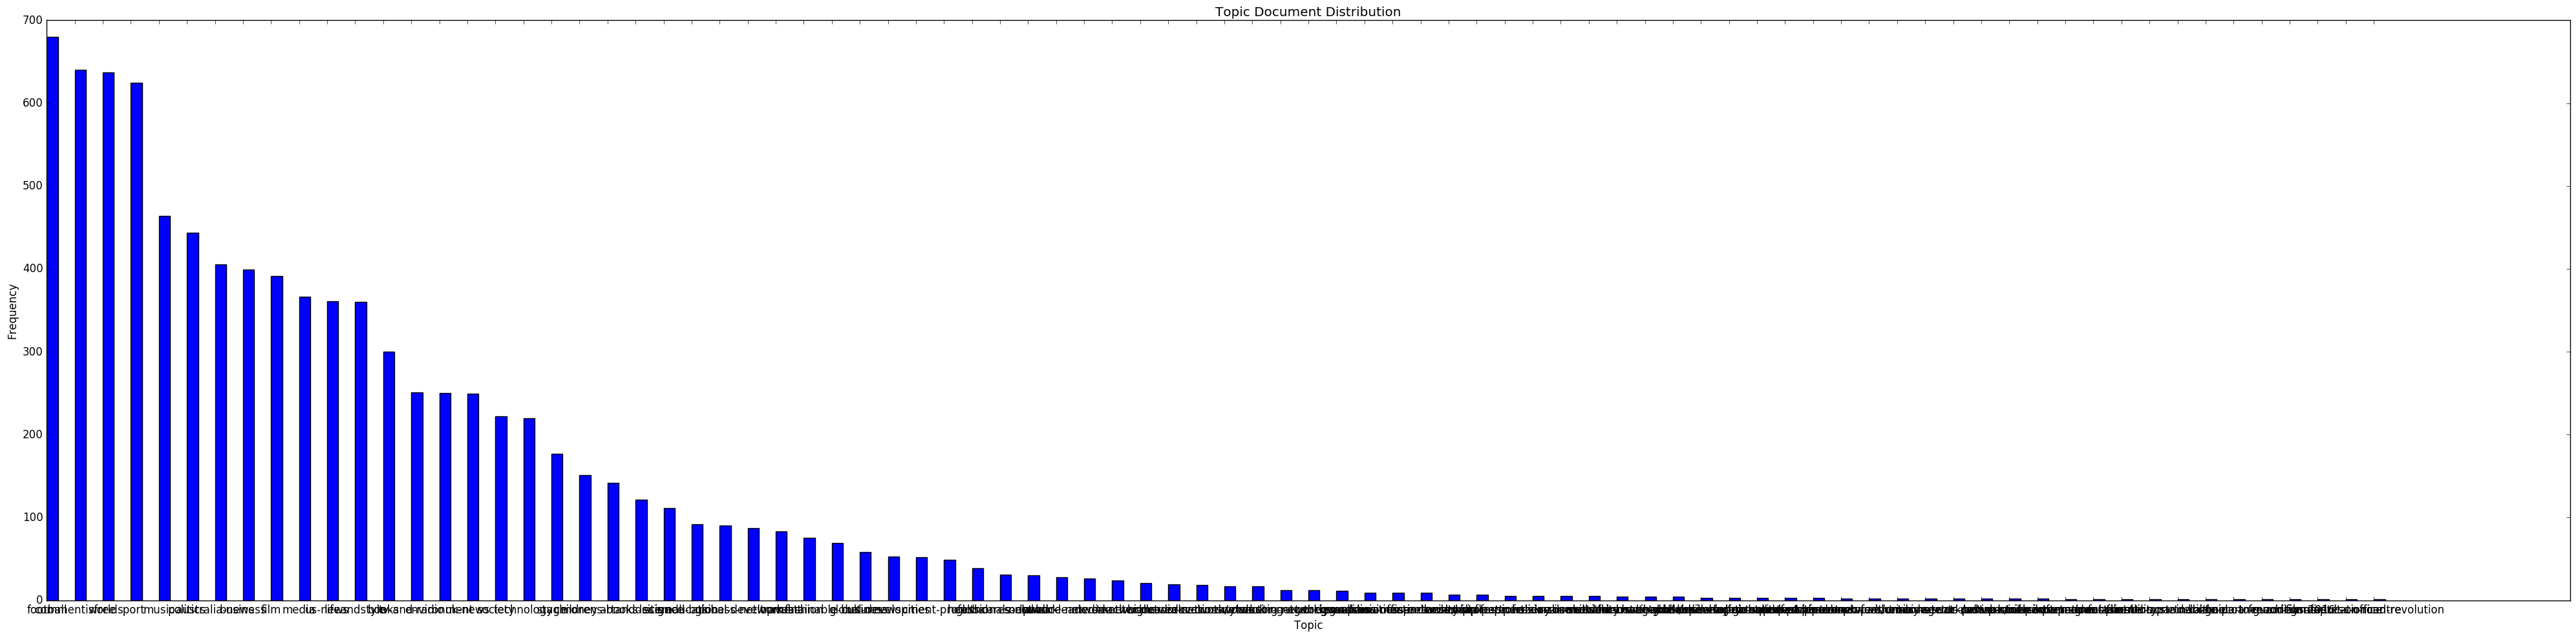

In [23]:
x_data = []
y_data = []
count = 0
for key, value in sorted(section_ids.items(), key=lambda x: len(x[1]), reverse=True):
    count += 1
    x_data.append(count)
    y_data.append(len(value))

ind = np.arange(0, len(y_data) * 2, 2)
fig = plt.figure(figsize=(40,10))
fig.patch.set_facecolor('w')
plt.bar(ind, y_data)
plt.xticks(ind, x_data)
plt.title("Topic Document Distribution")
plt.xlabel("Topic")
plt.ylabel("Frequency")
plt.tight_layout()
fig.savefig('tmp/size_chart_true.png')
plt.show()

In [33]:
topic_labels = []
for key, value in sorted(section_ids.items(), key=lambda x: len(x[1]), reverse=True):
    topic_labels.append(key)
topic_labels

['football',
 'commentisfree',
 'world',
 'sport',
 'music',
 'politics',
 'australia-news',
 'business',
 'film',
 'media',
 'us-news',
 'lifeandstyle',
 'books',
 'tv-and-radio',
 'environment',
 'uk-news',
 'society',
 'technology',
 'stage',
 'money',
 'childrens-books-site',
 'artanddesign',
 'science',
 'education',
 'small-business-network',
 'global-development',
 'travel',
 'fashion',
 'sustainable-business',
 'culture',
 'news',
 'cities',
 'global-development-professionals-network',
 'global',
 'healthcare-network',
 'law',
 'social-care-network',
 'public-leaders-network',
 'media-network',
 'teacher-network',
 'careers',
 'higher-education-network',
 'crosswords',
 'voluntary-sector-network',
 'housing-network',
 'media-network/marketing-agencies-association-partner-zone',
 'theguardian',
 'gnm-press-office',
 'guardian-masterclasses',
 'women-in-leadership',
 'small-business-network/kia-fleet-partner-zone',
 'society-professionals',
 'sap-partner-zone',
 'culture-professi

In [104]:
from collections import Counter

def topics_to_tags(topics, num_words):
    results = {}

    for k, vs in topics.items():
        results[k] = []
        for v in vs:
            results[k].append(docs[v]['tags'])

    tag_topics = sorted(results.items(), key=lambda x: len(x[1]), reverse=True)
    
    results = {}
    for topic in tag_topics:
        tag_count_topics = Counter([tag for tags in topic[1] for tag in tags ])
        tags = sorted(tag_count_topics.items(), key=lambda x: x[1], reverse=True)
        keywords = [k for k, v in tags]
        k = topic[0]
        results[k] = (len(topics[k]), keywords[:num_words])
    
    return results

In [105]:
original_topics = {}
for k, v in docs.items():
    try:
        original_topics[v['section_id']]
    except:
        original_topics[v['section_id']] = []
    
    original_topics[v['section_id']].append(k)
        
len(original_topics.keys())
ori_tags = sorted(topics_to_tags(original_topics, 20).items(), key=lambda x: x[1][0], reverse=True)

In [106]:
original_labels = {}
for k, v in docs.items():
    try:
        original_labels[v['section_id']]
    except:
        original_labels[v['section_id']] = []
    
    original_labels[v['section_id']].append(k)
        
original_labels = sorted(original_labels.items(), key=lambda x: len(x[1]), reverse=True)
for label in original_labels[:10]:
    print(label[0])

7
11
4
10
12
17
8
18
1
2


In [35]:
ori_tags[9]

(2,
 (366,
  ['Media',
   'UK news',
   'Television industry',
   'BBC',
   'Culture',
   'Newspapers',
   'Television & radio',
   'Politics',
   'Newspapers & magazines',
   'Television',
   'National newspapers',
   'Digital media',
   'John Whittingdale',
   'US news',
   'Media business',
   'Technology',
   'EU referendum',
   'Daily Mail',
   'Advertising',
   'Business']))

# Network-based Approach - Build the graph from scratch

In [34]:
g = ig.Graph()
for i, key in enumerate(token_keys):
    g.add_vertices(key)
    
print(g.vcount())

9095


In [35]:
g.delete_edges(g.es)
edges = []
for i, source in enumerate(token_keys):
    clear_output(wait=True)
    print('{0}\r'.format(i/len(token_keys)))
    for j, target in enumerate(token_keys):
        edges.append((source, target))
            
g.add_edges(edges)  
edges = [] 
print(g.ecount())

0.999890049477735
82719025


In [36]:
from sklearn.metrics.pairwise import cosine_similarity

count = 0
cos_sims = cosine_similarity(X_tfidf)
for i, source in enumerate(token_keys):
    sims = cos_sims[i]
    print('{0}\r'.format(i/len(token_keys)))
    clear_output(wait=True)
    for j, target in enumerate(token_keys):            
        g.es[count]["weight"] = sims[j]
        count += 1

print(g.ecount())

82719025


Remove duplicated and self-loop edges

In [37]:
g.simplify(multiple=True, loops=True, combine_edges="max")
print(g.ecount())

41354965


In [40]:
g.es[1]['weight']

0.063943441531837661

In [155]:
g.write_gml('tmp/igraph.gml')

In [39]:
sub_g = g.es.select(weight_ge=0.01).subgraph()

In [40]:
print("Nodes {}".format(sub_g.vcount()))
print("Edges {}".format(sub_g.ecount()))

Nodes 9095
Edges 34993969


In [80]:
print(sub_g.vs[1])
print(sub_g.vs[3])

igraph.Vertex(<igraph.Graph object at 0x118bf26d8>, 1, {'name': '2016-05-04-288'})
igraph.Vertex(<igraph.Graph object at 0x118bf26d8>, 3, {'name': '2016-05-26-109'})


In [87]:
sub_g.write_gml('tmp/sg_001.gml')

In [88]:
sg = sub_g.es.select(weight_ge=0.2).subgraph()
sg.write_gml('tmp/sg_02.gml')

# Apply Modularity

In [34]:
sub_g = ig.Graph.Read_GML('tmp/sg_02.gml')

In [35]:
def network_properties(g, community):
    print("Nodes {}".format(g.vcount()))
    print("Edges {}".format(g.ecount()))
    print("Diameter {}".format(g.diameter()))
    print("LCC {}".format(g.clusters().giant().vcount()))
    print("APL {}".format(g.average_path_length()))
    print("AD {}".format(sum(g.degree())/len(g.degree())))
    print("Giant Size {}".format(len(community.giant().vs())))
    print("NO of Communities {}".format(max(community.membership) + 1))
    print("Modularity {}".format(g.modularity(community.membership)))

In [36]:
sg = sub_g.es.select(weight_ge=0.2).subgraph()
communities = sg.community_multilevel(weights='weight',return_levels=True)
for com in communities:
    print(max(com.membership) + 1)
community = communities[-1]
print("Nodes {}".format(sg.vcount()))
print("Edges {}".format(sg.ecount()))
print("LCC {}".format(sg.clusters().giant().vcount()))
print("NO of Communities {}".format(max(community.membership) + 1))
print("Modularity {}".format(sg.modularity(community.membership)))
# community = sg.community_infomap(edge_weights='weight')
# community = sg.community_leading_eigenvector(weights='weight')

586
166
140
139
Nodes 8213
Edges 132243
LCC 7950
NO of Communities 139
Modularity 0.7987487477056004


# Reduced Data

In [25]:
reduced_docs = {}
for v in sg.vs():
    reduced_docs[v['name']] = docs[v['name']]

In [ ]:
sorted_reduced_docs = sorted(reduced_docs.items(), key=lambda x: x[0], reverse=True)

In [26]:
reduced_token_keys = [x[0] for x in sorted_reduced_docs]
reduced_token_values = [x[1]["text"] for x in sorted_reduced_docs]
print(len(reduced_token_values))

8213


In [27]:
reduced_tfidf_values = [x[1]['tfidf'] for x in sorted_reduced_docs]

In [28]:
reduced_X_tfidf = scipy.sparse.vstack((reduced_tfidf_values))
reduced_X_tfidf

<8213x69281 sparse matrix of type '<class 'numpy.float64'>'
	with 1089809 stored elements in Compressed Sparse Row format>

## Show contents of communities

In [145]:
with open('tmp/network_docs.txt', 'w+') as file:
    for i in range(max(community.membership) + 1):
        for v in community.subgraph(i).vs():
            file.write("Topic:{} File:{} Title:{}\n".format(i, v['name'], docs[v['name']]['webTitle']))

# Network Size Chart

In [37]:
def network_to_topics(com):
    topics = {}

    for i in range(max(com.membership) + 1):
        for v in com.subgraph(i).vs():
            topic_no = i
            try:
                topics[topic_no]
            except KeyError:
                topics[topic_no] = []

            topics[topic_no].append(v['name'])
    
    net_topics = {}
    count = 1
    for key, value in sorted(topics.items(), key=lambda x: len(x[1]), reverse=True):
        net_topics[count] = value
        count += 1
        
    return net_topics

In [38]:
net_topics = network_to_topics(community)
len(net_topics)

139

In [101]:
for key, value in docs.items():
    docs[key]['mod_topic'] = ''
    del docs[key]['mod_topic']

for key, value in net_topics.items():
    for v in value:
        docs[v]['mod_topic'] = key

docs['2016-05-20-1']['mod_topic']

18

In [96]:
def community_to_size_chart(net_topics):
    x_data = []
    y_data = []
    for key, value in net_topics.items():
        x_data.append(key)
        y_data.append(len(value))

    ind = np.arange(0, len(y_data) * 2, 2)
    fig = plt.figure(figsize=(40,10))
    fig.patch.set_facecolor('w')
    plt.bar(ind, y_data)
    plt.xticks(ind, x_data)
    plt.title("Topic Document Distribution - Modularity")
    plt.xlabel("Topic")
    plt.ylabel("Frequency")
    fig.tight_layout()
    fig.savefig('tmp/size_chart_net.png')
    plt.show()

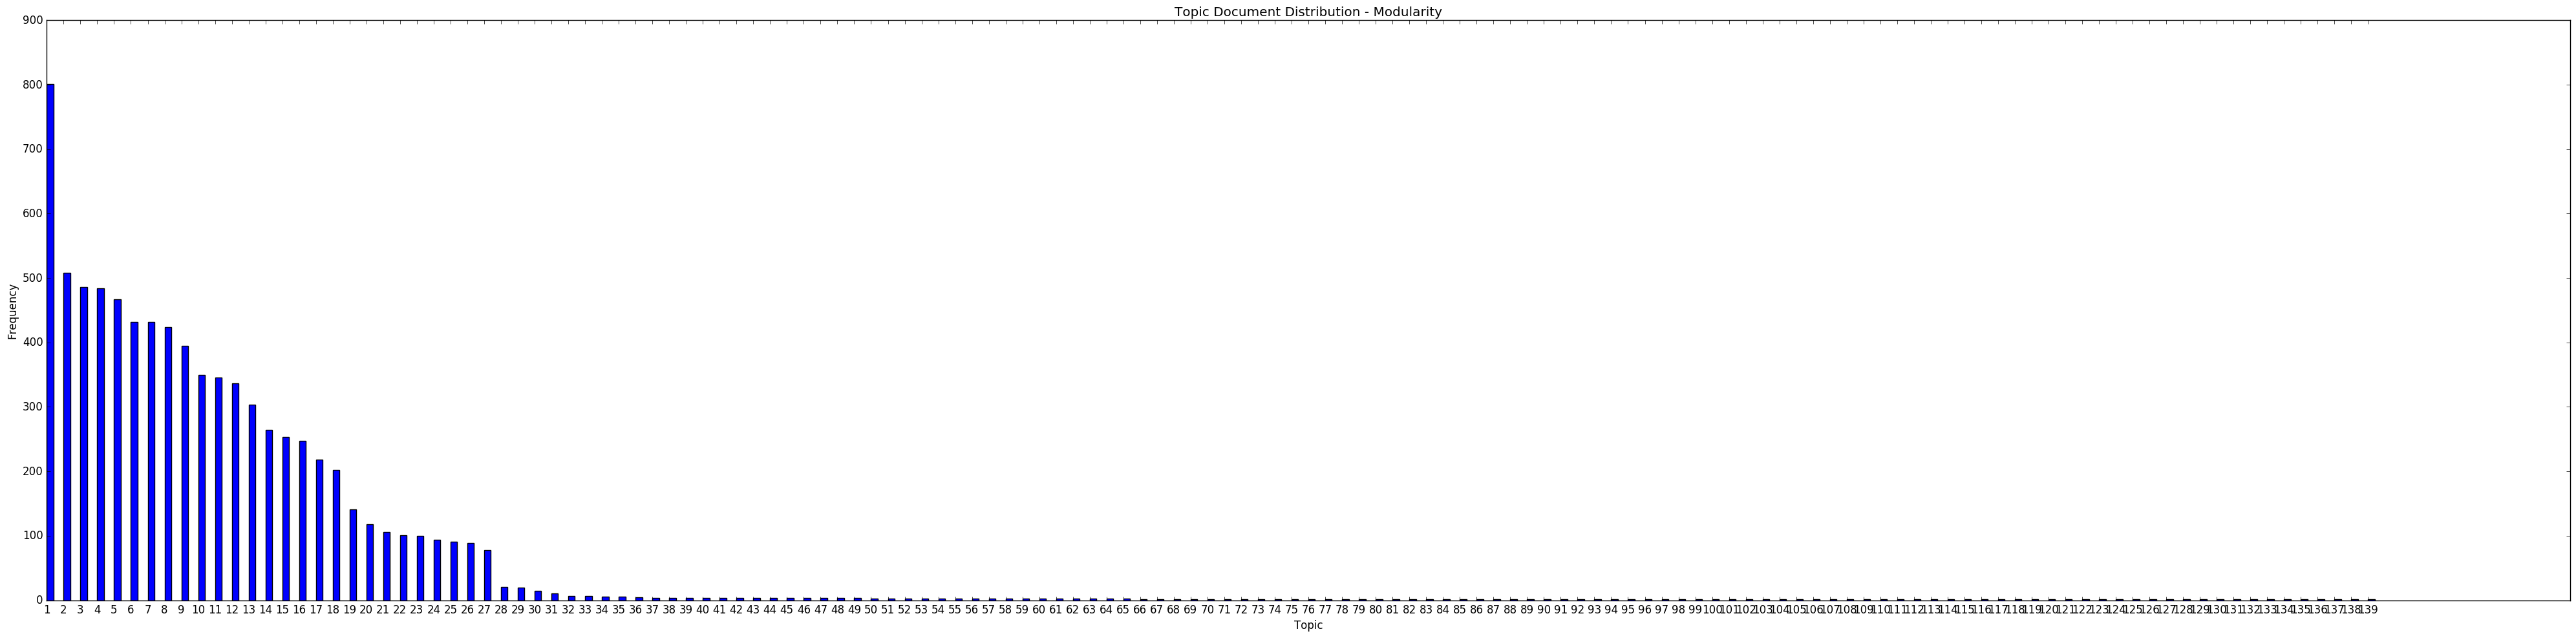

In [97]:
community_to_size_chart({k: v for k, v in net_topics.items()})

In [37]:
import scipy.stats as stats

def topics_to_prob_dist(topics):
    x_data = []
    y_data = []
    for key, value in topics.items():
        x_data.append(key)
        y_data.append(len(value))

    df = pd.DataFrame(y_data)
    # df.hist(weights=np.ones_like(df[df.columns[0]]*100.)/len(df))

    plt.hist(df, log=True, weights=np.ones_like(df[df.columns[0]]*100.)/len(df))
    plt.xlabel("Topic Size")
    plt.ylabel("Probability")

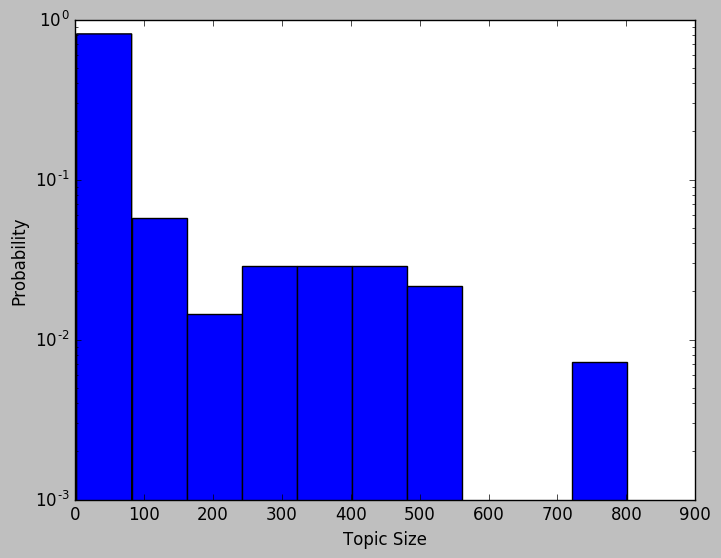

In [38]:
topics_to_prob_dist(net_topics)

In [38]:
net_tfidf_topics = {}
for k, vs in net_topics.items():
    net_tfidf_topics[k] = []
    for v in vs:
        net_tfidf_topics[k].append(docs[v]['tfidf'])

In [39]:
net_labels_true = {}

for k, vs in net_topics.items():
    net_labels_true[k] = []
    for v in vs:
        net_labels_true[k].append(docs[v]['section_id'])

In [51]:
net_labels_true1 = sorted(net_labels_true.items(), key=lambda x: len(x[1]), reverse=True)
net_labels_true1 = list(map(lambda x: x[1], net_labels_true1))

In [40]:
print("Overall Similarity {0:.3f}".format(intra_cluster_overall_similarity(net_tfidf_topics)))
print("Inter Cluster Overall Similarity Top {0:.3f}".format(inter_cluster_overall_similarity(net_tfidf_topics)))
print("Purity {0:.3f}".format(purity_weighted_score(len(net_labels_true.keys()), net_labels_true)))
print("Entropy {0:.3f}".format(entropy_weighted_score(len(net_labels_true.keys()), net_labels_true)))

Overall Similarity 0.525
Inter Cluster Overall Similarity Top 0.051
Purity 0.448
Entropy 0.610


In [44]:
print("Intra")
for i in np.arange(10,141,10):
    print("{0:.3f}".format(intra_cluster_overall_similarity({k: v for k, v in net_tfidf_topics.items() if k <= i})), end=",")

print("\nInter")
for i in np.arange(10,141,10):
    print("{0:.3f}".format(inter_cluster_overall_similarity({k: v for k, v in net_tfidf_topics.items() if k <= i})), end=",")
    
print("\nPurity")
for i in np.arange(10,141,10):
    print("{0:.3f}".format(purity_weighted_score(i, net_labels_true)), end=",")

print("\nEntropy")
for i in np.arange(10,141,10):
    print("{0:.3f}".format(entropy_weighted_score(i, net_labels_true)), end=",")

Intra
0.072,0.081,0.101,0.215,0.272,0.314,0.361,0.408,0.439,0.467,0.487,0.501,0.514,0.525,
Inter
0.405,0.320,0.244,0.171,0.131,0.108,0.090,0.079,0.071,0.065,0.061,0.057,0.053,0.051,
Purity
0.439,0.427,0.435,0.438,0.439,0.440,0.441,0.442,0.443,0.445,0.446,0.447,0.447,0.448,
Entropy
0.607,0.617,0.618,0.616,0.616,0.615,0.615,0.614,0.613,0.612,0.611,0.610,0.610,0.610,

In [43]:
print("\nEntropy")
for i in np.arange(1,11,1):
    print("{0:.3f}".format(entropy_score(net_labels_true[i])), end=",")


Entropy
0.299,0.624,0.786,0.738,0.624,0.735,0.570,0.798,0.484,0.625,

In [42]:
with open('tmp/network_docs.txt', 'w+') as file:
    for k, vs in net_topics.items():
        for v in vs:
            file.write("Topic:{} File:{} Title:{}\n".format(k, v, docs[v]['webTitle']))

# LDA

In [52]:
def lda_to_topics(lda_items, threshold):
    topics = {}

    for item in lda_items:
        topic_no = item[1]['lda']
        try:
            topics[topic_no]
        except:
            topics[topic_no] = []

        if item[1]['lda_value'] >= threshold:
            topics[topic_no].append(item[0])

    lda_topics = {}
    lda_keys = {}
    count = 1
    for key, value in sorted(topics.items(), key=lambda x: len(x[1]), reverse=True):
        if len(value) > 0:
            lda_topics[count] = value
            lda_keys[count] = key
        count += 1
        
    return lda_topics, lda_keys

In [56]:
from gensim import matutils
from gensim.models.ldamodel import LdaModel
from gensim.models.wrappers import LdaVowpalWabbit

In [ ]:
pickle.dump(reduced_token_values, open('tmp/reduced_token_values.pickle', 'wb'))

In [81]:
from sklearn.feature_extraction.text import CountVectorizer

print("Processing Count")

vectorizer = CountVectorizer(tokenizer=tokenize, stop_words='english')
X_count = vectorizer.fit_transform(reduced_token_values)
vocab = vectorizer.get_feature_names()

print(X_count.shape)

Processing Count
(8213, 83592)


In [75]:
X_count = pickle.load(open('tmp/X_count_R.pickle', 'rb'))

In [50]:
num_topics = 139

In [ ]:
lda_model = LdaVowpalWabbit('/usr/local/Cellar/vowpal-wabbit/8.1.1/bin/vw',
                     corpus=matutils.Sparse2Corpus(X_count.T),
                     num_topics=num_topics,
                     alpha=(1/num_topics),
                     eta=(1/num_topics),
                     passes=100,
                     id2word=dict([(i, s) for i, s in enumerate(vocab)]))

# alpha=0.1 eta=0.01 http://www.cs.princeton.edu/~blei/papers/HoffmanBleiBach2010b.pdf

In [69]:
lda_model.save('tmp/gensim_lda_' + str(num_topics) + '_100_k_k')

In [53]:
lda_model = LdaVowpalWabbit.load('tmp/gensim_lda_' + str(num_topics) + '_100_k_k')

In [76]:
doc_topic_prob_mat = lda_model[matutils.Sparse2Corpus(X_count.T)]
print(len(doc_topic_prob_mat))

8213


In [66]:
for i, mat in enumerate(doc_topic_prob_mat):
    clear_output(wait=True)
    print('{0}\r'.format(i/len(doc_topic_prob_mat)))
    max_prob = max(mat, key=lambda x: x[1])
    reduced_docs[reduced_token_keys[i]]['lda'] = max_prob[0]
    reduced_docs[reduced_token_keys[i]]['lda_value'] = max_prob[1]
    reduced_docs[reduced_token_keys[i]]['lda_vector'] = mat

0.9998782418117619


In [120]:
pickle.dump(reduced_docs, open('tmp/docs_lda_' + str(num_topics) + '_100.pickle', 'wb'))

In [57]:
reduced_docs = pickle.load(open('tmp/docs_lda_' + str(num_topics) + '_100.pickle', 'rb'))

In [67]:
lda_items = sorted(reduced_docs.items(), key=lambda x: x[1]['lda'])
lda_topics, lda_keys = lda_to_topics(lda_items, 0.0)

In [68]:
len(lda_items)

8213

In [69]:
def lda_to_size_chart(lda_topics):
    print(len(lda_topics.keys()))

    x_data = []
    y_data = []
    for key, value in lda_topics.items():
        x_data.append(key)
        y_data.append(len(value))

    ind = np.arange(0, len(y_data) * 2, 2)
    fig = plt.figure()
    plt.bar(ind, y_data)
    plt.xticks(ind, x_data)
    plt.title("Topic Document Distribution - LDA")
    plt.xlabel("Topic")
    plt.ylabel("Frequency")
    plt.tight_layout()
    fig.savefig('tmp/size_chart_lda.png')
    plt.show()

81


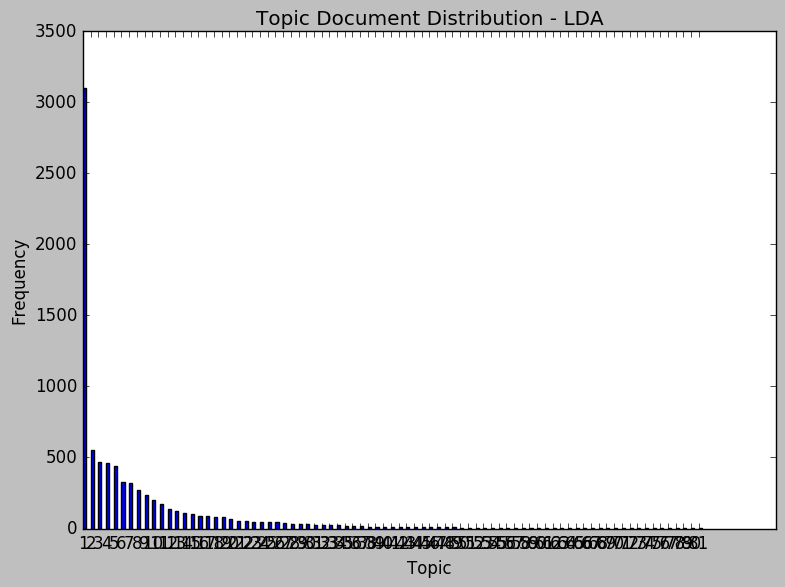

In [70]:
lda_to_size_chart({k: v for k, v in lda_topics.items()})

In [71]:
lda_tfidf_topics = {}

for k, vs in lda_topics.items():
    lda_tfidf_topics[k] = []
    for v in vs:
        lda_tfidf_topics[k].append(reduced_docs[v]['tfidf'])

In [72]:
lda_labels_true = {}

for k, vs in lda_topics.items():
    lda_labels_true[k] = []
    for v in vs:
        lda_labels_true[k].append(reduced_docs[v]['section_id'])

In [73]:
print("Overall Similarity {0:.3f}".format(intra_cluster_overall_similarity(lda_tfidf_topics)))
print("Weighted Similarity {0:.3f}".format(intra_cluster_weighted_similarity(lda_tfidf_topics)))
print("Inter Cluster {0:.3f}".format(inter_cluster_overall_similarity(lda_tfidf_topics)))
print("Purity {0:.3f}".format(purity_weighted_score(len(lda_labels_true.keys()), lda_labels_true)))
print("Entropy {0:.3f}".format(entropy_weighted_score(len(lda_labels_true.keys()), lda_labels_true)))

Overall Similarity 0.288
Weighted Similarity 0.032
Inter Cluster 0.253
Purity 0.099
Entropy 0.853


# Test LDA

In [46]:
from gensim import matutils
from gensim.models.ldamodel import LdaModel
from gensim.models.wrappers import LdaVowpalWabbit
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.corpora import Dictionary

In [58]:
from sklearn.feature_extraction.text import CountVectorizer

print("Processing Count")

vectorizer = CountVectorizer(tokenizer=tokenize, stop_words='english')
X_count = vectorizer.fit_transform(token_values)
vocab = vectorizer.get_feature_names()

print(X_count.shape)

Processing Count
(9095, 91268)


In [43]:
X_count = pickle.load(open('tmp/X_count.pickle', 'rb'))
vocab = pickle.load(open('tmp/X_count_vocab.pickle', 'rb'))

print(X_count.shape)
print(vocab[0])

(9095, 69281)
0


In [44]:
num_topics = 40

In [66]:
lda_model = LdaVowpalWabbit('/usr/local/Cellar/vowpal-wabbit/8.1.1/bin/vw',
                     corpus=matutils.Sparse2Corpus(X_count.T),
                     num_topics=num_topics,
                     alpha=(1/num_topics),
                     eta=(1/num_topics),
                     passes=100,
                     id2word=dict([(i, s) for i, s in enumerate(vocab)]))

In [340]:
train_log_prep_gensim = lda_model.log_perplexity(train_corpus)
test_log_prep_gensim = lda_model.log_perplexity(test_corpus)
train_preplexity_gensim = np.exp(-train_log_prep_gensim)
test_preplexity_gensim = np.exp(-test_log_prep_gensim)
print(train_log_prep_gensim)
print(test_log_prep_gensim)
print(train_preplexity_gensim)
print(test_preplexity_gensim)

-14.012468
-14.008645
1217692.2171
1213045.86691


In [67]:
lda_model.save('tmp/gensim_lda_' + str(num_topics) + '_100_k_k')

In [47]:
lda_model = LdaVowpalWabbit.load('tmp/gensim_lda_' + str(num_topics) + '_100_k_k')

## Load LDA

In [48]:
doc_topic_prob_mat = lda_model[matutils.Sparse2Corpus(X_count.T)]
print(len(doc_topic_prob_mat))

9095


In [49]:
for i, mat in enumerate(doc_topic_prob_mat):
    clear_output(wait=True)
    print('{0}\r'.format(i/len(doc_topic_prob_mat)))
    max_prob = max(mat, key=lambda x: x[1])
    docs[token_keys[i]]['lda'] = max_prob[0]
    docs[token_keys[i]]['lda_value'] = max_prob[1]
    docs[token_keys[i]]['lda_vector'] = mat

0.999890049477735


In [50]:
lda_items = sorted(docs.items(), key=lambda x: x[1]['lda'])

In [308]:
with open('tmp/lda_docs.txt', 'w+') as file:
    for item in lda_items:
        file.write("Topic:{} File:{} Title:{}\n".format(item[1]['lda'], item[0], item[1]['webTitle']))

In [53]:
lda_items = sorted(docs.items(), key=lambda x: x[1]['lda'])
lda_topics, lda_keys = lda_to_topics(lda_items, 0.0)

In [54]:
for key, value in lda_topics.items():
    for v in value:
        docs[v]['lda_topic'] = key
docs['2016-05-20-284'].keys()

dict_keys(['lda_topic', 'tfidf', 'section_id', 'top_tfidf', 'webPublicationDate', 'keyword', 'lda_vector', 'webUrl', 'authors', 'sectionId', 'webTitle', 'lda_value', 'lda', 'guardianId', 'mod_topic', 'text', 'apiUrl', 'body', 'tags', 'id'])

In [76]:
lda_tfidf_topics = {}

for k, vs in lda_topics.items():
    lda_tfidf_topics[k] = []
    for v in vs:
        lda_tfidf_topics[k].append(docs[v]['tfidf'])

In [77]:
lda_labels_true = {}

for k, vs in lda_topics.items():
    lda_labels_true[k] = []
    for v in vs:
        lda_labels_true[k].append(docs[v]['section_id'])

In [101]:
lda_labels_true1 = sorted(net_labels_true.items(), key=lambda x: len(x[1]), reverse=True)
lda_labels_true1 = list(map(lambda x: x[1], lda_labels_true1))

In [78]:
print("Overall Similarity {0:.3f}".format(intra_cluster_overall_similarity(lda_tfidf_topics)))
print("Weighted Similarity {0:.3f}".format(intra_cluster_weighted_similarity(lda_tfidf_topics)))
print("Inter Cluster {0:.3f}".format(inter_cluster_overall_similarity(lda_tfidf_topics)))
print("Purity {0:.3f}".format(purity_weighted_score(len(lda_labels_true.keys()), lda_labels_true)))
print("Entropy {0:.3f}".format(entropy_weighted_score(len(lda_labels_true.keys()), lda_labels_true)))

Overall Similarity 0.177
Weighted Similarity 0.023
Inter Cluster 0.498
Purity 0.083
Entropy 0.844


In [43]:
print("Intra")
for i in np.arange(10,141,10):
    print("{0:.3f}".format(intra_cluster_overall_similarity({k: v for k, v in lda_tfidf_topics.items() if k <= i})), end=",")

print("\nInter")
for i in np.arange(10,141,10):
    print("{0:.3f}".format(inter_cluster_overall_similarity({k: v for k, v in lda_tfidf_topics.items() if k <= i})), end=",")
    
print("\nPurity")
for i in np.arange(10,141,10):
    print("{0:.3f}".format(purity_weighted_score(i, lda_labels_true)), end=",")

print("\nEntropy")
for i in np.arange(10,141,10):
    print("{0:.3f}".format(entropy_weighted_score(i, lda_labels_true)), end=",")

Intra


NameError: name 'lda_tfidf_topics' is not defined

In [184]:
print("\nEntropy")
for i in np.arange(1,11,1):
    print("{0:.3f}".format(entropy_score(lda_labels_true[i])), end=",")


Entropy
0.776,0.613,0.798,0.819,0.601,0.270,0.568,0.791,0.723,0.812,

# Heatmap

In [80]:
def topics_to_heatmap_data(topics):
    d = []
    for key, value in sorted(topics.items(), key=lambda x: x[0]):
        h = {}
        for v in value:
            h[v] = True
        d.append(h)

    return(d)

In [92]:
original_topics = {}
for k, v in docs.items():
    try:
        original_topics[v['section_id']]
    except:
        original_topics[v['section_id']] = []
    
    original_topics[v['section_id']].append(k)
        
ori_topics = {}
count = 1
for key, value in sorted(original_topics.items(), key=lambda x: len(x[1]), reverse=True):
    ori_topics[count] = value
    count += 1
len(ori_topics.keys())

84

In [102]:
net_data = topics_to_heatmap_data(net_topics)
# lcm_data = topics_to_heatmap_data(lcm_topics)
lda_data = topics_to_heatmap_data(lda_topics)
ori_data = topics_to_heatmap_data(ori_topics)

In [108]:
from sklearn.feature_extraction import DictVectorizer

vectorizer = DictVectorizer()
vectors  = ori_data + net_data 
X_dict = vectorizer.fit_transform(vectors)

print(X_dict.shape)

(223, 9095)


In [109]:
len(net_data[0])
len(ori_data[0])

680

In [110]:
ori_vectors = X_dict[0:len(ori_data)]
net_vectors = X_dict[len(ori_data):]

In [117]:
from sklearn.metrics.pairwise import cosine_similarity

sub_sims = cosine_similarity(ori_vectors, net_vectors)
sub_sims.shape

(84, 139)

In [114]:
def filter_max_in_sims(sims):
    sims = sims.copy()
    for sim in sims:
        low_values_indices = sim < np.amax(sim)
        sim[low_values_indices] = 0 
    return sims

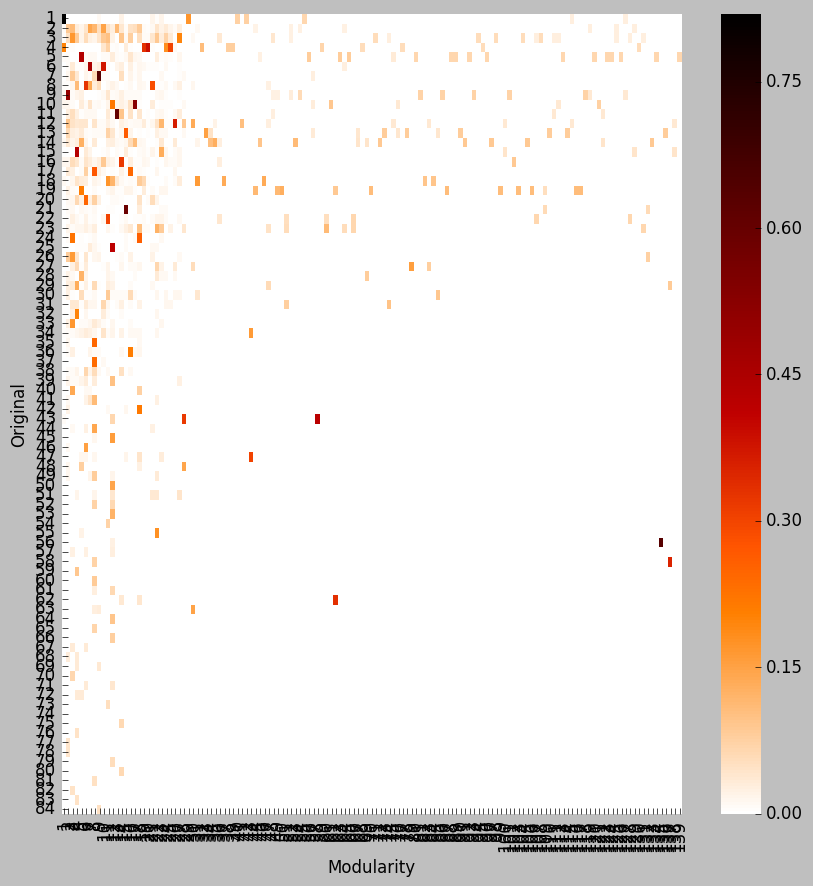

In [118]:
import seaborn as sns

filtered_sims = sub_sims

fig, ax = plt.subplots(figsize=(10, 10))
sns_plt = sns.heatmap(filtered_sims, cmap=plt.cm.gist_heat_r)
sns_plt.set(xticklabels=np.arange(1,140), yticklabels=(-np.sort(-np.arange(1,85))))
# sns_plt.invert_yaxis()
plt.xlabel("Modularity")
plt.ylabel("Original")

# Size to topic table + keywords

In [55]:
import itertools
from collections import Counter

def keywords_to_keyword_table(topics, n):
    result = {}
    for topic in topics:
        keywords = []
        for top in topic[1]:
            keywords += list(top['feature'])
        net_keywords = Counter(keywords)
        net_keywords = sorted(net_keywords.items(), key=lambda x: x[1], reverse=True)
        keywords2 = list(map(lambda x: x[0], net_keywords))
        result[topic[0]] = (len(topic[1]), keywords2[:n])
    return result

In [119]:
def topics_to_keywords(topics):
    results = {}

    for k, vs in topics.items():
        results[k] = []
        for v in vs:
            top_df = docs[v]['top_tfidf']
#             results[k].append(top_df)
            results[k].append(top_df[(top_df.tfidf >= 0.1) & (top_df.tfidf <= 0.9)])

    results = sorted(results.items(), key=lambda x: len(x[1]), reverse=True)
    
    return results

In [126]:
topics_matrix = lda_model.show_topics(formatted=False, num_words=10, num_topics=lda_model.num_topics)
lda_topic_keywords = {}
count = 1
for topic in topics_matrix:
    lda_topic_keywords[count] = [str(word[1]) for word in topic]
    count += 1

lda_topic_keywords.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40])

In [74]:
lda_keywords = {}
for k, v in sorted(lda_topics.items(), key=lambda x: len(x[1]), reverse=True):
    lda_keywords[k] = (len(v), lda_topic_keywords[k])

In [120]:
net_keywords = keywords_to_keyword_table(topics_to_keywords(net_topics), 5)

In [109]:
# lda_tags = topics_to_tags(lda_topics, 10)
net_tags = topics_to_tags(net_topics, 10)
ori_tags = topics_to_tags(original_topics, 10)

In [123]:
import csv

lda_s_k = sorted(lda_topic_keywords.items(), key=lambda x: x[1][0], reverse=True)
net_s_k = sorted(net_keywords.items(), key=lambda x: x[1][0], reverse=True)
# lda_s_t = sorted(lda_tags.items(), key=lambda x: x[1][0], reverse=True)
# net_s_t = sorted(net_tags.items(), key=lambda x: x[1][0], reverse=True)
# ori_s_t = sorted(ori_tags.items(), key=lambda x: x[1][0], reverse=True)

length = len(net_s_k)
rows = []
for i in range(length):
    row = [i+1]
#     row += [ori_s_t[i][1][0], ori_s_t[i][1][1]]
    row += [net_s_k[i][1][0], net_s_k[i][1][1]]
#     row += [lda_s_k[i][0], lda_s_k[i][1]]
#     row += [lda_s_k[i][1][0], net_s_k[i][1][0], lda_s_k[i][1][1], net_s_k[i][1][1], lda_s_t[i][1][1], net_s_t[i][1][1]]    
    rows.append(row)

with open('tmp/keywords.csv', 'w+') as file:    
    for row in rows:
        writer = csv.writer(file, delimiter=';')
        writer.writerow(row)

In [127]:
lda_topic_keywords[1]

['mansoor',
 'bach',
 'coleman',
 'pac',
 'iphon',
 'adelson',
 'dale',
 'mullah',
 'klein',
 'pite']

In [134]:
from gensim.models.coherencemodel import CoherenceModel

In [135]:
%time cm = CoherenceModel(topics=[lda_topic_keywords[1]], corpus=matutils.Sparse2Corpus(X_count.T), dictionary=dict([(i, s) for i, s in enumerate(vocab)]), coherence='u_mass')
cm.get_coherence()

TypeError: __init__() got an unexpected keyword argument 'topics'

In [ ]:
import csv

rows = []
for i, row in enumerate(filtered_sims):
    sim =  np.amax(row)
    net =  max(range(len(row)), key=lambda x: row[x]) + 1
    lda = i + 1
    rows.append([lda, net, lda_keywords[lda][0], net_keywords[net][0], sim, lda_keywords[lda][1], net_keywords[net][1]])

with open('tmp/matching.csv', 'w+') as file:    
    for row in sorted(rows, key=lambda x: x[0]):
        writer = csv.writer(file, delimiter=';')
        writer.writerow(row)

# LCM

In [463]:
lda_model.minimum_probability=0.0

mat_lda = []
for i, m in enumerate(doc_topic_prob_mat):
    clear_output(wait=True)
    print('{0}\r'.format(i/len(token_keys)))
    a = []
    for n in m:
        if n[1] >= 0.01:
            a.append(n[1])
        else:
            a.append(0)
    mat_lda.append(a)

0.999890049477735


In [464]:
mat_lda = np.mat(mat_lda)
pickle.dump(mat_lda, open('tmp/mat.pickle', 'wb'))
mat_lda[1]

matrix([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.03189059,  0.        ,  0.        ,  0.        ,
          0.02538236,  0.        ,  0.03909163,  0.        ,  0.        ,
          0.02472269,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.03493306,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.

## Add LDA to docs

In [465]:
for i, key in enumerate(token_keys):
    docs[key]['lda_matrix'] = scipy.sparse.csr_matrix(mat_lda[i])
  
docs['2016-05-20-28']['lda_matrix']

<1x200 sparse matrix of type '<class 'numpy.float64'>'
	with 19 stored elements in Compressed Sparse Row format>

In [466]:
lda_mat_topics = {}

for k, vs in lda_topics.items():
    lda_mat_topics[k] = []
    for v in vs:
        lda_mat_topics[k].append(docs[v]['lda_matrix'])

# Hierarchical Clustering

In [399]:
from scipy.cluster.hierarchy import dendrogram

def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [415]:
from sklearn.metrics.pairwise import cosine_similarity

dist = 1 - cosine_similarity(reduced_X_tfidf)

In [416]:
X_tfidf.toarray()[:3]

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [417]:
from scipy.cluster.hierarchy import average
from scipy.cluster.hierarchy import linkage

In [418]:
print("Start Hierarchical Clustering...")

linkage_matrix = average(dist) #de fine the linkage_matrix using hierachical clustering pre-computed distances
# linkage_matrix = linkage(dist, metric='cosine', method='average')

print("Done Hierarchical Clustering...")

Start Hierarchical Clustering...
Done Hierarchical Clustering...


In [313]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

c, coph_dists = cophenet(linkage_matrix, pdist(dist))
c

0.77491382903670991

In [419]:
pickle.dump(linkage_matrix, open('tmp/linkage_matrix_average.pickle', 'wb'))

In [24]:
pickle.dump(dist, open('tmp/dist.pickle', 'wb'))

In [71]:
linkage_matrix = pickle.load(open('tmp/linkage_matrix_average3.pickle', 'rb'))

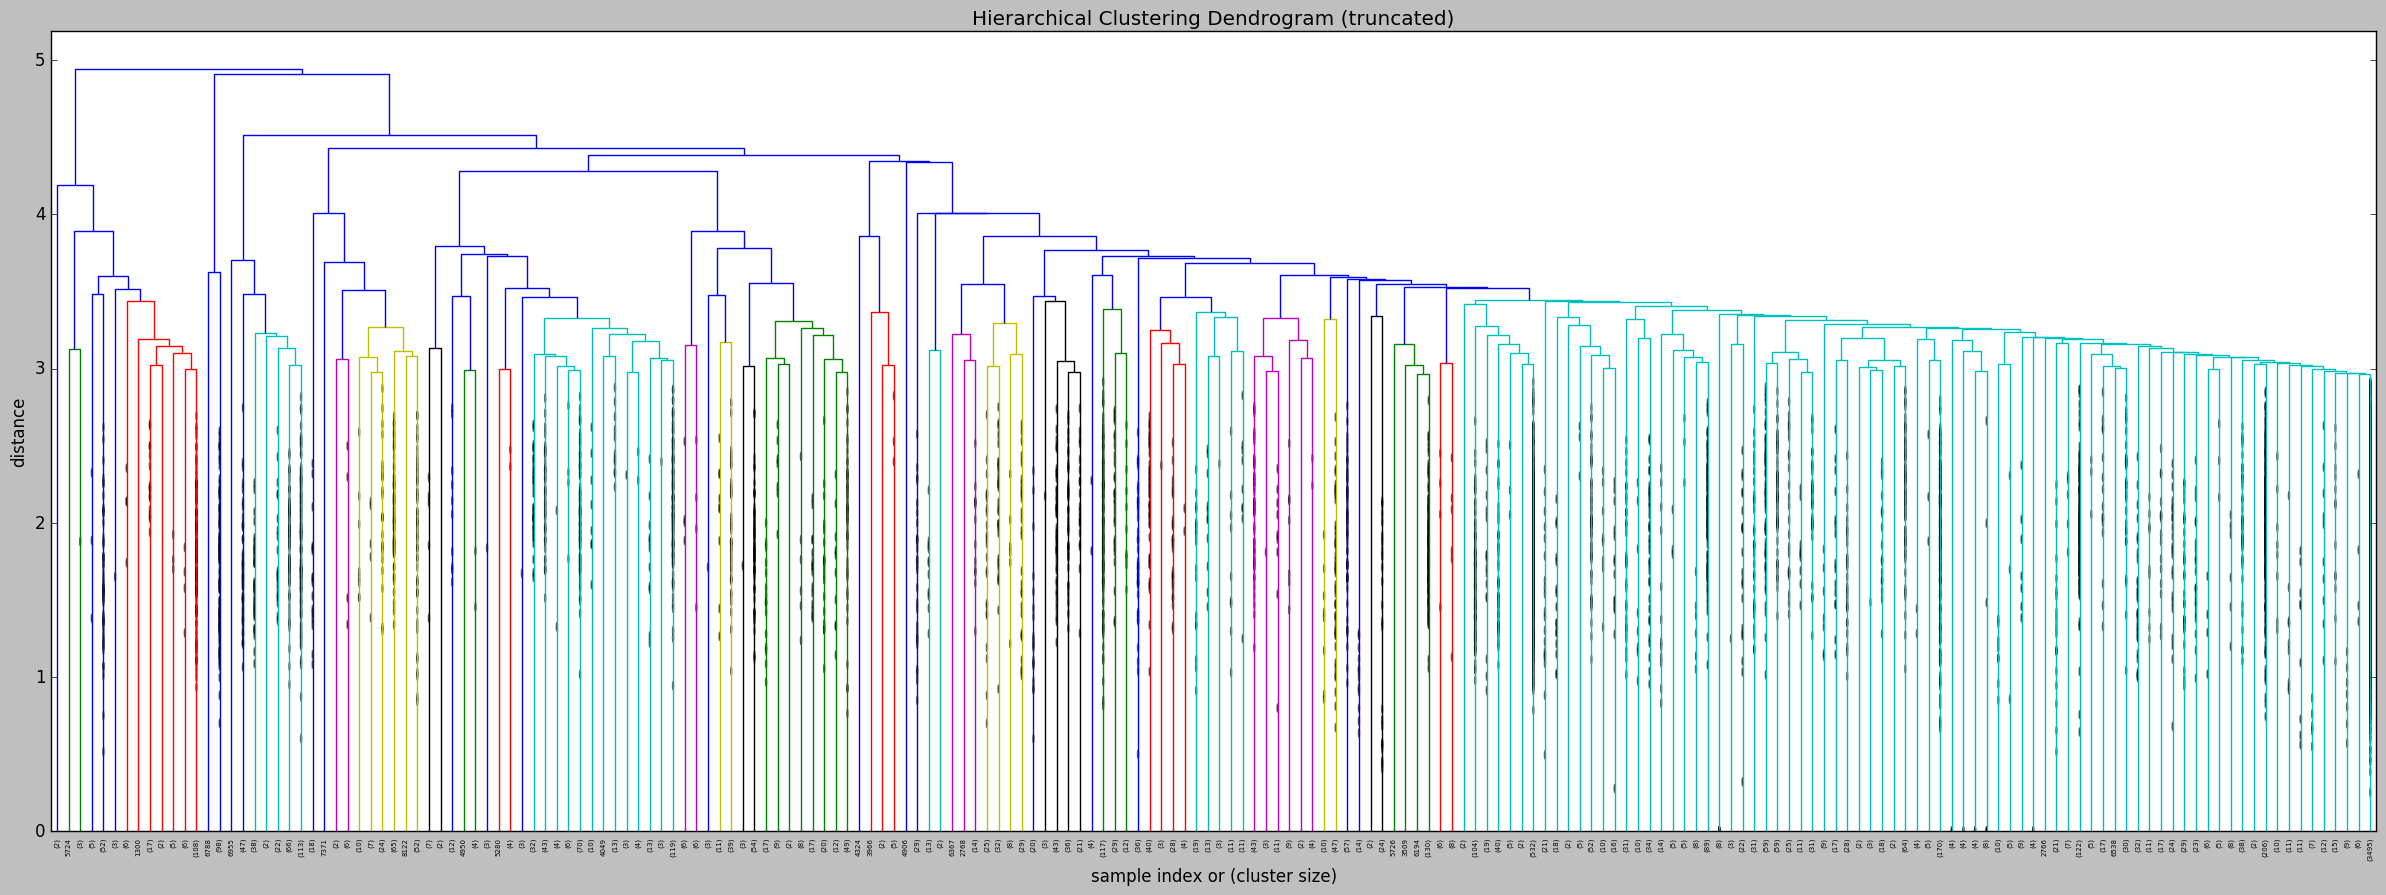

In [421]:
plt.figure(figsize=(30, 10))
fancy_dendrogram(
    linkage_matrix,
    truncate_mode='lastp',
    p=200,
    leaf_rotation=90.,
    leaf_font_size=5.,
    show_contracted=True,
    annotate_above=200,  # useful in small plots so annotations don't overlap
)
plt.show()

In [72]:
from scipy.cluster.hierarchy import fclusterdata, fcluster

def cluster_indices(cluster_assignments):
    n = cluster_assignments.max()
    indices = []
    for cluster_number in range(1, n + 1):
        indices.append(np.where(cluster_assignments == cluster_number)[0])
    return indices

# Compute the clusters.
cluster_assignments = fcluster(linkage_matrix, 139, criterion="maxclust")

# Print the indices of the data points in each cluster.
num_clusters = cluster_assignments.max()
print("%d clusters" % num_clusters)
indices = cluster_indices(cluster_assignments)

print("Giant Size:", len(max(indices, key=lambda x: len(x))))

# for k, ind in enumerate(indices):
#     print("cluster", k + 1, " (Length:)", len(ind), "=", ind)

for k, ind in enumerate(indices):
    for i in ind:
        reduced_docs[reduced_token_keys[i]]['hclust'] = k

139 clusters
Giant Size: 3841


In [73]:
hclust_items = []
for item in reduced_docs.items():
    hclust_items.append((item[0], item[1]['hclust']))
len(hclust_items)

8213

In [74]:
with open('tmp/hclust_docs.txt', 'w+') as file:
    for item in hclust_items:
        file.write("Topic:{} File:{} Title:{}\n".format(item[1]['hclust'], item[0], item[1]['webTitle']))

TypeError: 'int' object is not subscriptable

In [75]:
topics = {}

for i in range(num_clusters):
    topics[i] = []
    
for item in hclust_items:
    topic_no = item[1]
    topics[topic_no].append(item[0])
    
print(len(topics.keys()))

hclust_topics = {}
count = 1
for key, value in sorted(topics.items(), key=lambda x: len(x[1]), reverse=True):
    hclust_topics[count] = value
    count += 1

139


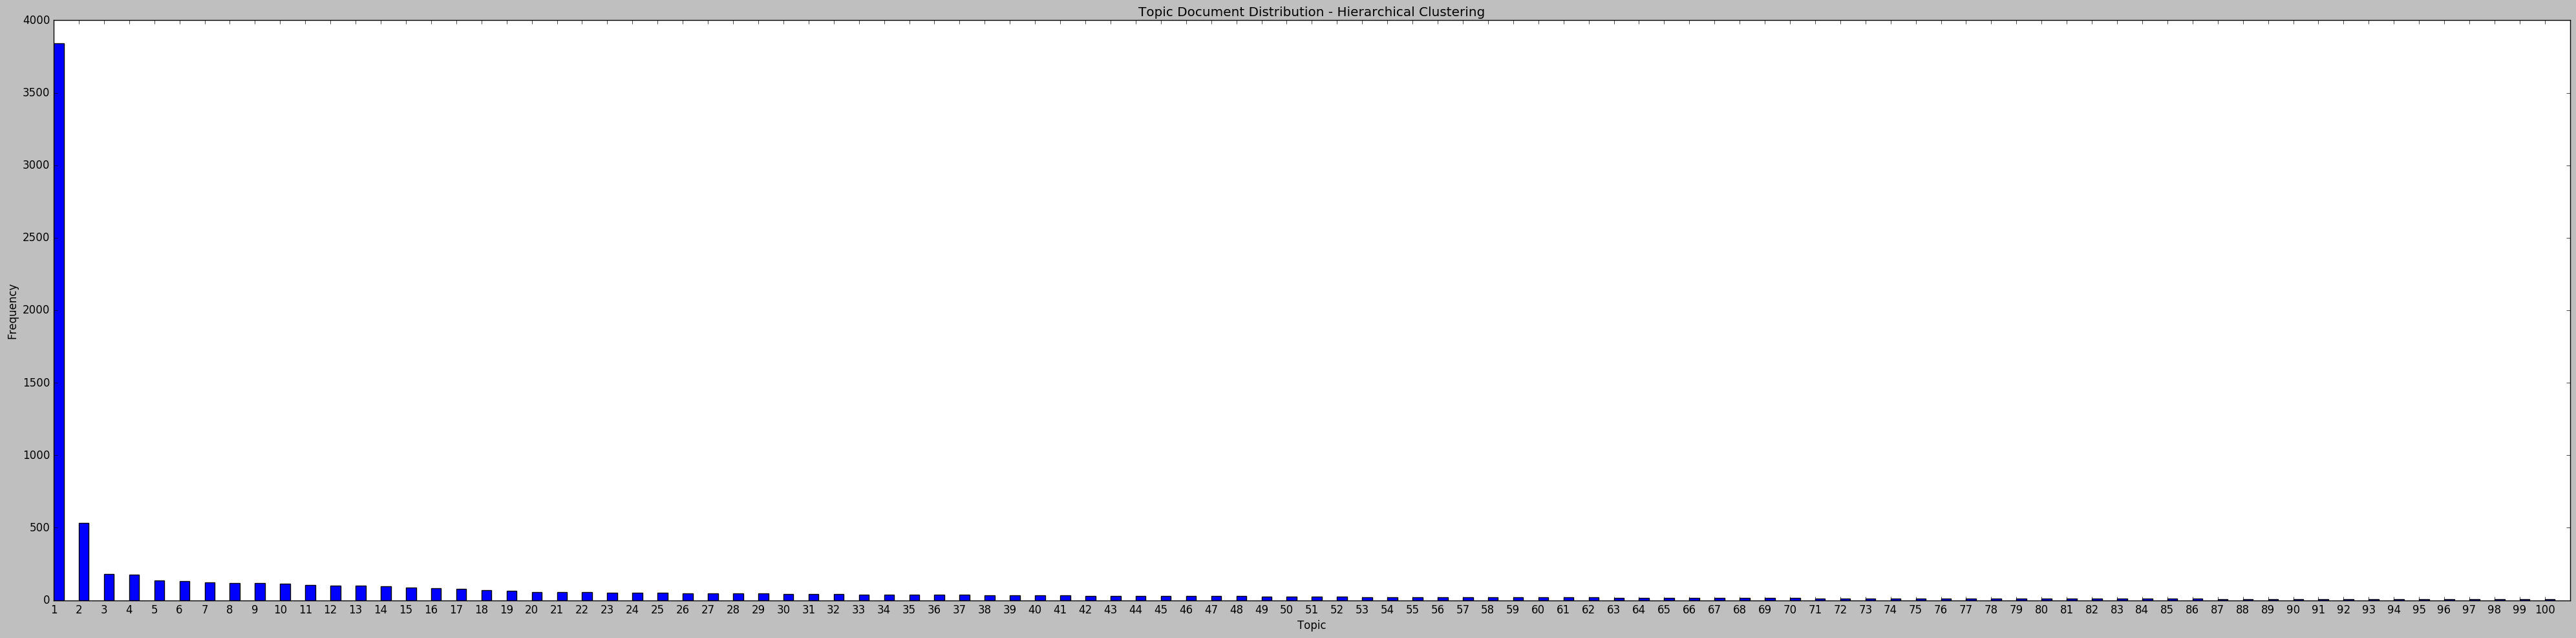

In [78]:
x_data = []
y_data = []
for key, value in sorted(hclust_topics.items(), key=lambda x: len(x[1]), reverse=True):
    if key <= 100:
        x_data.append(key)
        y_data.append(len(value))

ind = np.arange(0, len(y_data) * 2, 2)
fig = plt.figure(figsize=(40,10))
plt.bar(ind, y_data)
plt.xticks(ind, x_data)
plt.title("Topic Document Distribution - Hierarchical Clustering")
plt.xlabel("Topic")
plt.ylabel("Frequency")
plt.tight_layout()
fig.savefig('tmp/size_chart_hclust100.png')
plt.show()

In [84]:
hclust_tfidf_topics = {}

for k, vs in hclust_topics.items():
    hclust_tfidf_topics[k] = []
    for v in vs:
        hclust_tfidf_topics[k].append(docs[v]['tfidf'])

In [85]:
hclust_labels_true = {}

for k, vs in hclust_topics.items():
    hclust_labels_true[k] = []
    for v in vs:
        hclust_labels_true[k].append(docs[v]['section_id'])

In [86]:
hclust_labels_true.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139])

In [87]:
print("Overall Similarity {0:.3f}".format(intra_cluster_overall_similarity(hclust_tfidf_topics)))
print("Weighted Similarity {0:.3f}".format(intra_cluster_weighted_similarity(hclust_tfidf_topics)))
print("Inter Cluster {0:.3f}".format(inter_cluster_overall_similarity(hclust_tfidf_topics)))
print("Purity {0:.3f}".format(purity_weighted_score(len(hclust_labels_true.keys()), hclust_labels_true)))
print("Entropy {0:.3f}".format(entropy_weighted_score(len(hclust_labels_true.keys()), hclust_labels_true)))

Overall Similarity 0.210
Weighted Similarity 0.038
Inter Cluster 0.254
Purity 0.106
Entropy 0.861


In [459]:
entropy_score(hclust_labels_true[6])

0.4117272067108933

# KMeans

In [41]:
from sklearn.cluster import KMeans

In [48]:
num_clusters = 139

km = KMeans(n_clusters=num_clusters)

%time km.fit(reduced_X_tfidf)

CPU times: user 17min 20s, sys: 1min 5s, total: 18min 26s
Wall time: 18min 48s


KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=194, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [38]:
clusters = km.labels_.tolist()

In [53]:
# for k, v in reduced_docs.items():
#     del reduced_docs[k]['section_id']
    
for k, v in reduced_docs.items():
    reduced_docs[k]['section_id'] = section_id[v['sectionId']]

In [39]:
for i, cluster in enumerate(clusters):
    print('{0}\r'.format(i/len(clusters)))
    clear_output(wait=True)
    reduced_docs[reduced_token_keys[i]]['km'] = cluster

0.9998782418117619


In [502]:
pickle.dump(km, open('tmp/km_139.pickle', 'wb'))

In [55]:
km = pickle.load(open('tmp/km_1394.pickle', 'rb'))

In [56]:
def km_to_topics(km_items):
    topics = {}

    for item in km_items:
        topic_no = item[1]
        try:
            topics[topic_no]
        except:
            topics[topic_no] = []
        topics[topic_no].append(item[0])

    km_topics = {}
    count = 1
    for key, value in sorted(topics.items(), key=lambda x: len(x[1]), reverse=True):
        km_topics[count] = value
        count += 1

    return km_topics

In [57]:
km_items = []
for item in reduced_docs.items():
    km_items.append((item[0], item[1]['km']))

In [58]:
km_items[0][0]

'2016-05-24-202'

In [59]:
km_topics = km_to_topics(km_items)

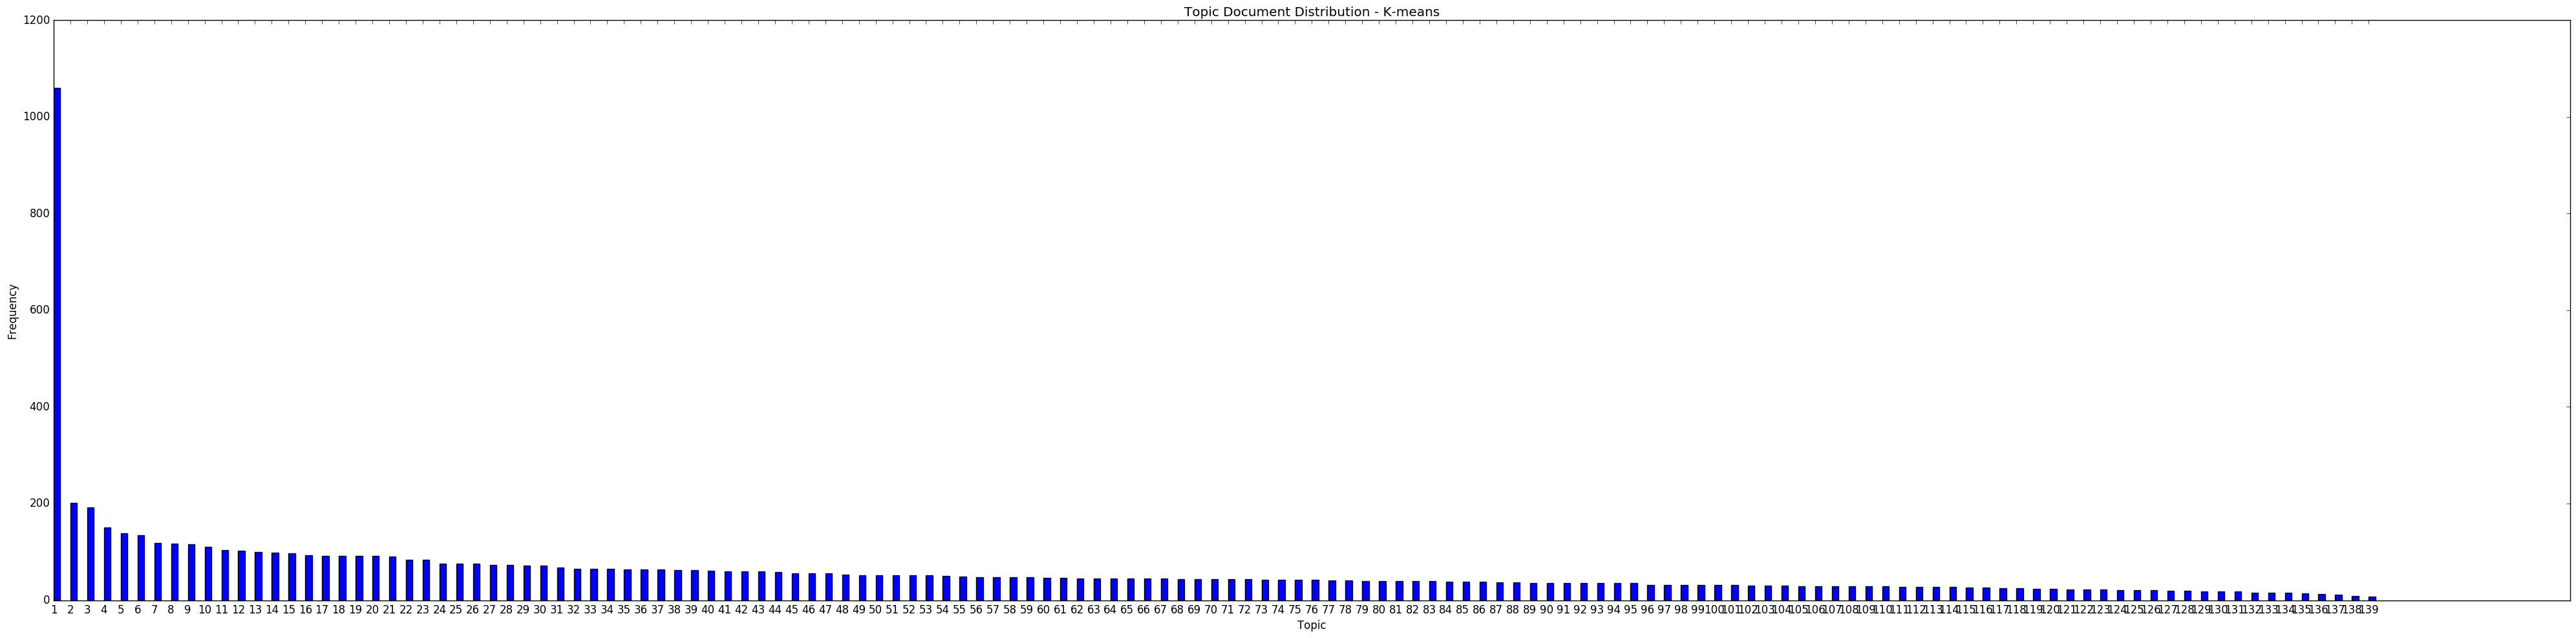

In [81]:
x_data = []
y_data = []
for key, value in sorted(km_topics.items(), key=lambda x: len(x[1]), reverse=True):
    if key <= 100:
        x_data.append(key)
        y_data.append(len(value))

ind = np.arange(0, len(y_data) * 2, 2)
fig = plt.figure(figsize=(40,10))
fig.patch.set_facecolor('w')
plt.bar(ind, y_data)
plt.xticks(ind, x_data)
plt.title("Topic Document Distribution - K-means")
plt.xlabel("Topic")
plt.ylabel("Frequency")
fig.tight_layout()
fig.savefig('tmp/size_chart_km100.png')
plt.show()

In [61]:
km_tfidf_topics = {}

for k, vs in km_topics.items():
    km_tfidf_topics[k] = []
    for v in vs:
        km_tfidf_topics[k].append(docs[v]['tfidf'])

In [62]:
km_labels_true = {}

for k, vs in km_topics.items():
    km_labels_true[k] = []
    for v in vs:
        km_labels_true[k].append(docs[v]['section_id'])

In [63]:
print("Overall Similarity {0:.3f}".format(intra_cluster_overall_similarity(km_tfidf_topics)))
print("Weighted Similarity {0:.3f}".format(intra_cluster_weighted_similarity(km_tfidf_topics)))
print("Inter Cluster {0:.3f}".format(inter_cluster_overall_similarity(km_tfidf_topics)))
print("Purity {0:.3f}".format(purity_weighted_score(len(km_labels_true.keys()), km_labels_true)))
print("Entropy {0:.3f}".format(entropy_weighted_score(len(km_labels_true.keys()), km_labels_true)))

Overall Similarity 0.049
Weighted Similarity 0.038
Inter Cluster 0.489
Purity 0.117
Entropy 0.918


In [64]:
print("Intra")
for i in np.arange(10,101,10):
    print("{0:.3f}".format(intra_cluster_overall_similarity({k: v for k, v in km_tfidf_topics.items() if k <= i})), end=",")

print("\nInter")
for i in np.arange(10,101,10):
    print("{0:.3f}".format(inter_cluster_overall_similarity({k: v for k, v in km_tfidf_topics.items() if k <= i})), end=",")
    
print("\nPurity")
for i in np.arange(10,101,10):
    print("{0:.3f}".format(purity_weighted_score(i, km_labels_true)), end=",")

print("\nEntropy")
for i in np.arange(10,101,10):
    print("{0:.3f}".format(entropy_weighted_score(i, km_labels_true)), end=",")

Intra
0.029,0.030,0.032,0.033,0.034,0.036,0.037,0.038,0.039,0.040,
Inter
0.798,0.741,0.702,0.674,0.650,0.628,0.607,0.591,0.579,0.562,
Purity
0.097,0.102,0.105,0.107,0.108,0.110,0.111,0.112,0.113,0.113,
Entropy
0.873,0.886,0.893,0.899,0.903,0.905,0.908,0.910,0.912,0.914,

# Visualization

In [31]:
def add_community_to_graph(key, graph, com):
    for i in range(max(com.membership) + 1):
        for v in com.subgraph(i).vs():
            node = graph.vs().find(name=v['name'])
            node['Community'] = docs[v['name']][key]